# Trend, seasonality, cycle  Removal followed by catboost

Time series models tend to perform better when the dataset is 'stationary'.

A stationary series properties do not depend on the time value of a series. In statistics this means it has a constant mean, variance and no seasonality.  See <a href="https://otexts.com/fpp2/stationarity.html#fig:stationary">Forecasting: Principles and Practice</a> for examples of Stationary and non stationary datasets.
    
To get a constant mean, remove the trend.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)
    

# Data
Use the tunnel dataset from <a href="https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data">Kaggle</a>.   It tracks the number of cars traveling through through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005

In [3]:
#read data convert the Day dolumn to pandas datetime
df = pd.read_csv("../datasets/kaggle/tunnel.csv", parse_dates=["Day"])

#day is really date, change column name
df=df.rename(columns={"Day": "Date"})

df=df.set_index("Date")

#set a time index (just an integer from 0 to len dataframe)
df['Time']=np.arange(len(df))

## Time series constituent parts

Time series consists of a trend, seasonal component(s), cyclic component(s) and leftover residual.  
A time series can be either additive or multiplicative<br><br>
<b>Additive Time-Series:</b> components are added. An additive trend indicates a linear trend, and an additive seasonality indicates the same frequency (width) and amplitude (height) of seasonal cycles.<br>
`Time-Series = trend + seasonality + noise`<br>
![](./additive.png)<br>
<b>Multiplicative Time-Series:</b> components are multiplied. A multiplicative trend indicates a non-linear trend (curved trend line), and a multiplicative seasonality indicates increasing/decreasing frequency (width) and/or amplitude (height) of seasonal cycles.(Notice an increase in the amplitude of seasonality in below figure).
An example of when this pattern occurs when is increasing sales over time for a product<br>
`Time-Series = trend * seasonality * noise`
![](./multiplicative.png)<br>

See <a href="https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7">Time Series From Scratch — Decomposing Time Series Data</a> for original content

## Lets look at data using seasonal_decompose to see if series is multiplicative or additive

In [4]:
df

,NumVehicles,Time
Date,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4
...,...,...
2005-11-12,104646,742
2005-11-13,94424,743
2005-11-14,112165,744


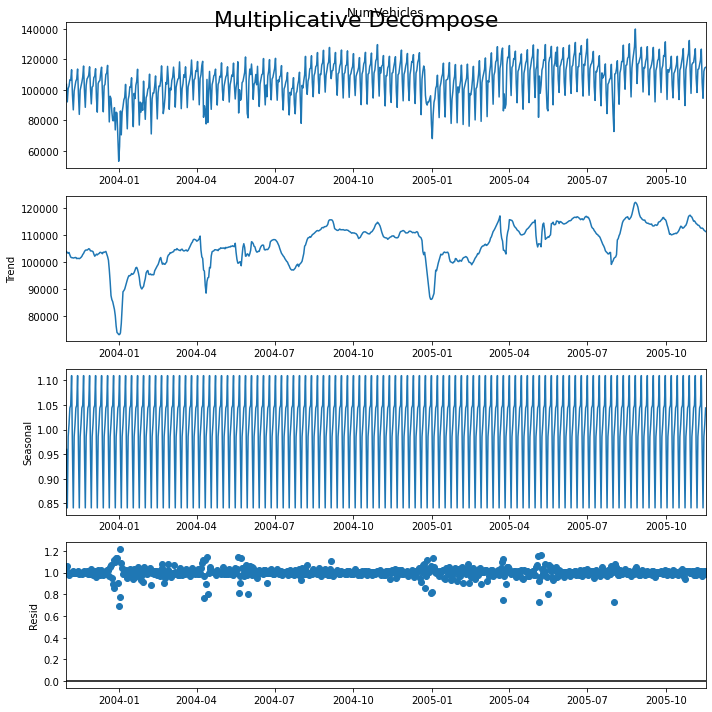

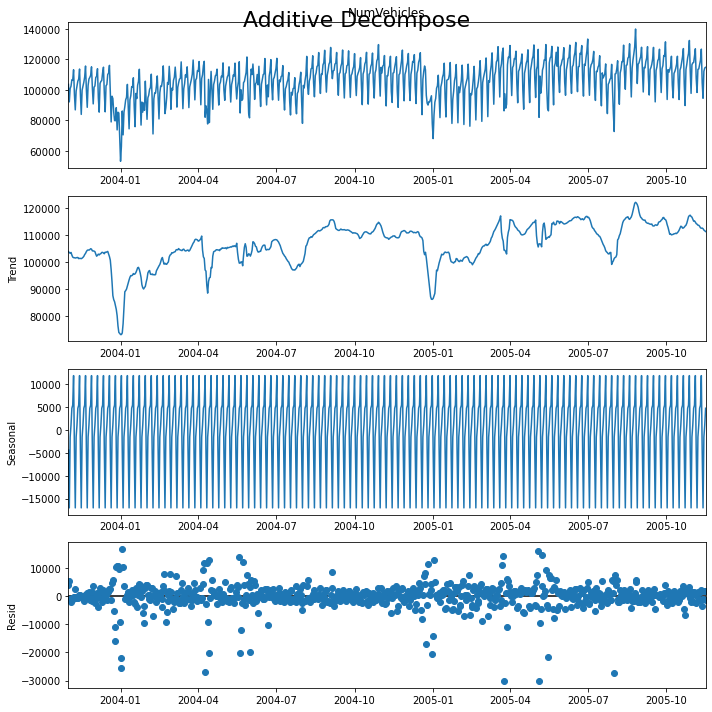

In [5]:
# Change the default figsize
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['NumVehicles'], model='multiplicative', extrapolate_trend='freq')

# # Additive Decomposition
result_add = seasonal_decompose(df['NumVehicles'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

## There are no visable remaining patterns in the residuals for each although Multiplicative residuals have a smaller variance

## lets split out a test set.  <mark>You cannot use train_test_split with time series data. The earliest data is training data, the latest data is test data

In [6]:
def get_train_test(df,numb_test_rows=100):
    df_train=df.iloc[:-numb_test_rows,:].copy()
    print(df_train.shape)
    df_test=df.iloc[-numb_test_rows:,:].copy()
    print(df_test.shape)
    return df_train, df_test

df_train, df_test = get_train_test(df)

(647, 2)
(100, 2)


## Find and remove trend
do this only on training set

In [7]:
import utils as ut
mod1=ut.train_model(df_train.Time.values.reshape(-1,1), df_train.NumVehicles)
preds=mod1.predict(df_train.Time.values.reshape(-1,1))

In [8]:
#remove trend
df_train.NumVehicles = df_train.NumVehicles-preds

## Find and remove seasonality
There are several ways to do this:

1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.

2. Seasonal difference the series (subtract the value of previous season from the current value)

3. Divide the series by the seasonal index obtained from STL decomposition


We will use method 3 

/home/keith/anaconda3/envs/data301/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_17783/1737249755.py:13: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(df_train.NumVehicles);


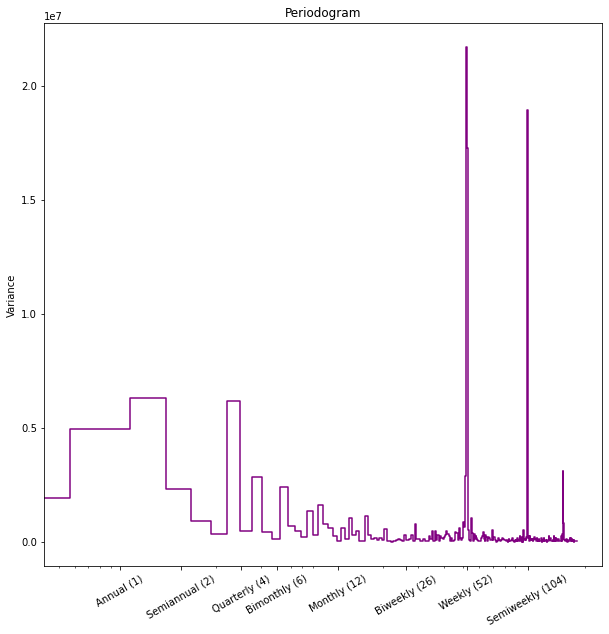

In [12]:
from scipy.signal import periodogram
fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
freqencies, spectrum = periodogram(
    df_train.NumVehicles,
    fs=fs,
    detrend='linear',
    window="boxcar",
    scaling='spectrum',
)

spectrum

plot_periodogram(df_train.NumVehicles);

In [17]:
len(result_mul.seasonal)

640

[]

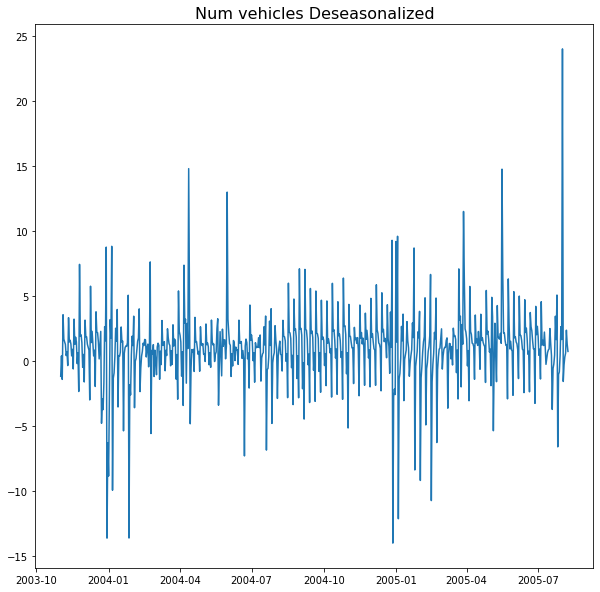

In [13]:
# Time Series Decomposition
result_mul = seasonal_decompose(df_train['NumVehicles'], model='additive', extrapolate_trend='freq')

# Deseasonalize
df_train['NumVehicles_ds'] = df_train.NumVehicles.values / result_mul.seasonal

plt.plot(df_train['NumVehicles_ds'])
plt.title('Num vehicles Deseasonalized', fontsize=16)
plt.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

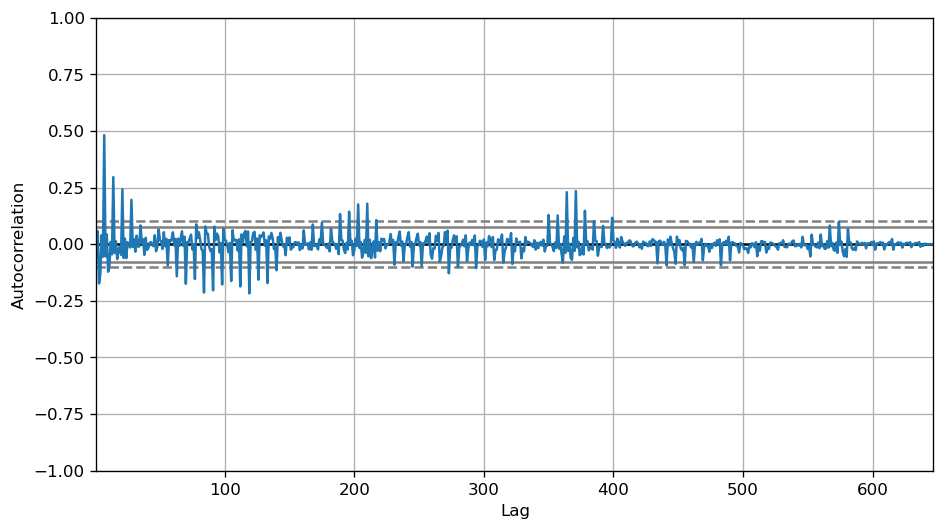

In [14]:
#lets see if there is an autocorrelation, if so then there is probably some sort of cycle
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df_train.NumVehicles_ds.tolist())

## Every 7 days have a high autocorrelation, so difference it
So difference with the value 7 days before<br>
<mark>NOTE: save original values so we can do inverse transform

In [15]:
#so difference to to remove the seasonality
df_train['NumVehicles_ds']=df_train['NumVehicles']- df_train['NumVehicles'].shift(7)
df_train=df_train.dropna()

In [16]:
df_train.head()

,NumVehicles,Time,NumVehicles_ds
Date,,,
2003-11-08,-1749.296801,7,-6879.69784
2003-11-09,-11765.682207,8,-5389.69784
2003-11-10,595.932388,9,-1750.69784
2003-11-11,3633.546982,10,-248.69784
2003-11-12,7066.161576,11,-1011.69784


## Periodogram

In [17]:

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/tmp/ipykernel_17783/3384970460.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(df_train.NumVehicles);


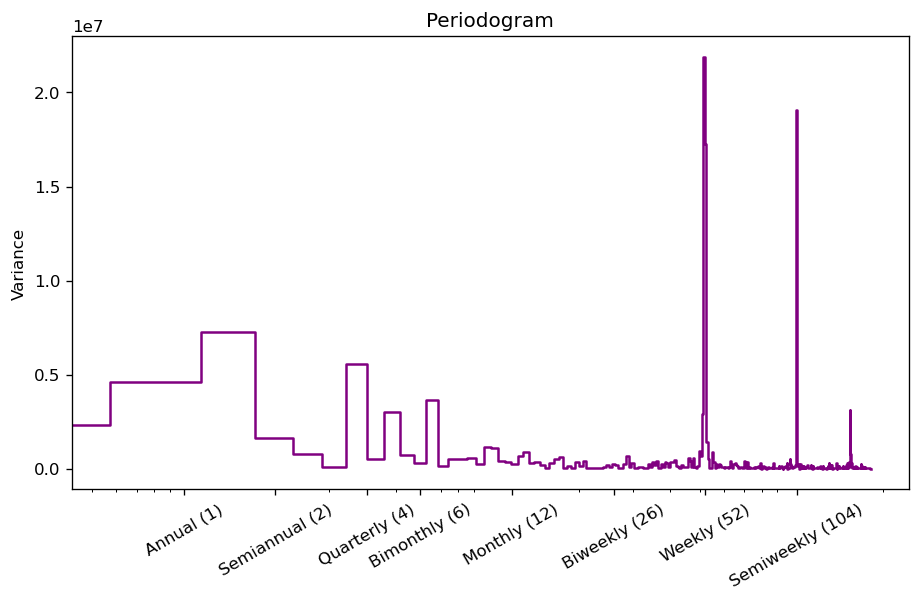

In [18]:
plot_periodogram(df_train.NumVehicles);

## Other stuff

In [56]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
df['day']=[d.day for d in df.index]
df['week'] = [d.week for d in df.index]
#convert the index to datetime and get the days of the week and add to the dataframe
df['dayofweek'] = pd.to_datetime(df.index).day_name()
df.head()
years = df['year'].unique()


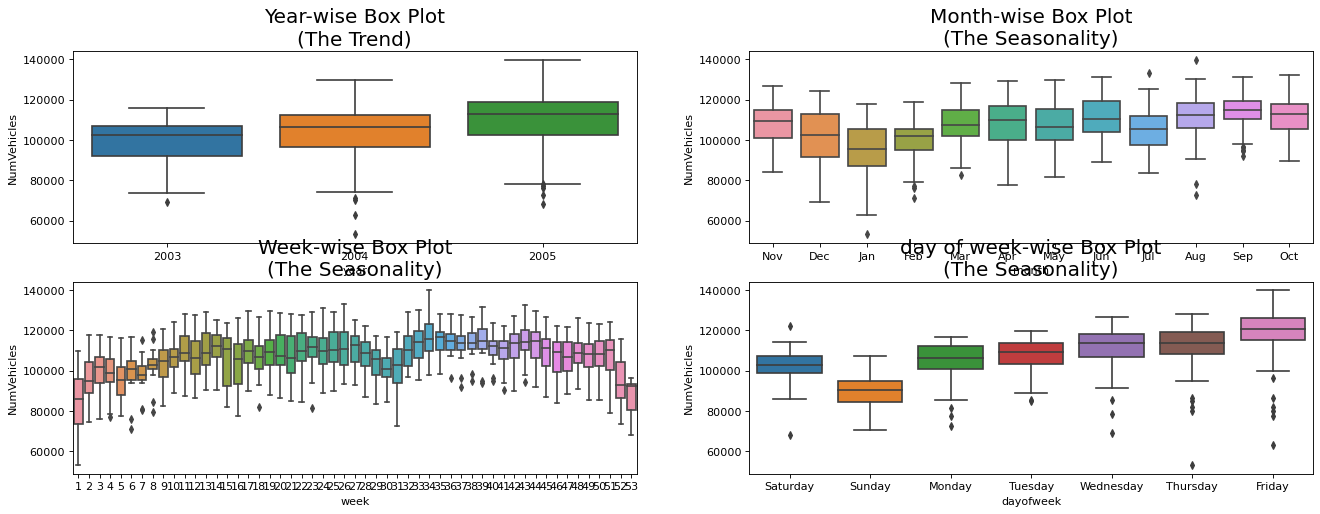

In [57]:
# Draw Plot
fig, axes = plt.subplots(2, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='NumVehicles', data=df, ax=axes[0,0])
sns.boxplot(x='month', y='NumVehicles', data=df, ax=axes[0,1])
sns.boxplot(x='week', y='NumVehicles', data=df, ax=axes[1,0])
sns.boxplot(x='dayofweek', y='NumVehicles', data=df, ax=axes[1,1])

# Set Title
axes[0,0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[0,1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1,0].set_title('Week-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[1,1].set_title('day of week-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Let statsmodels seasonal_decompose do it all


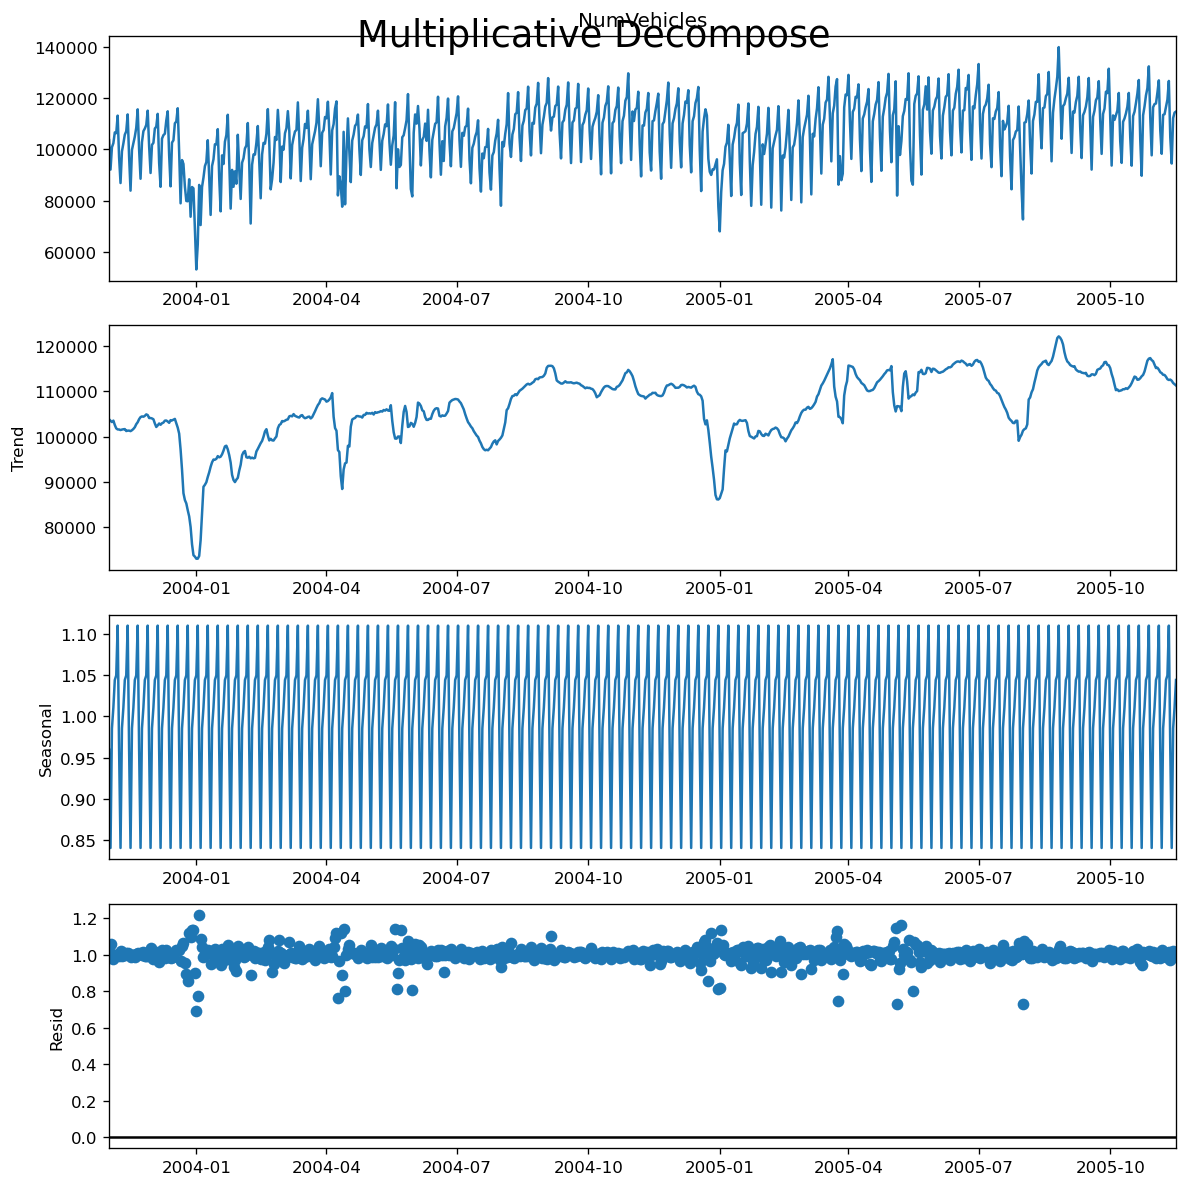

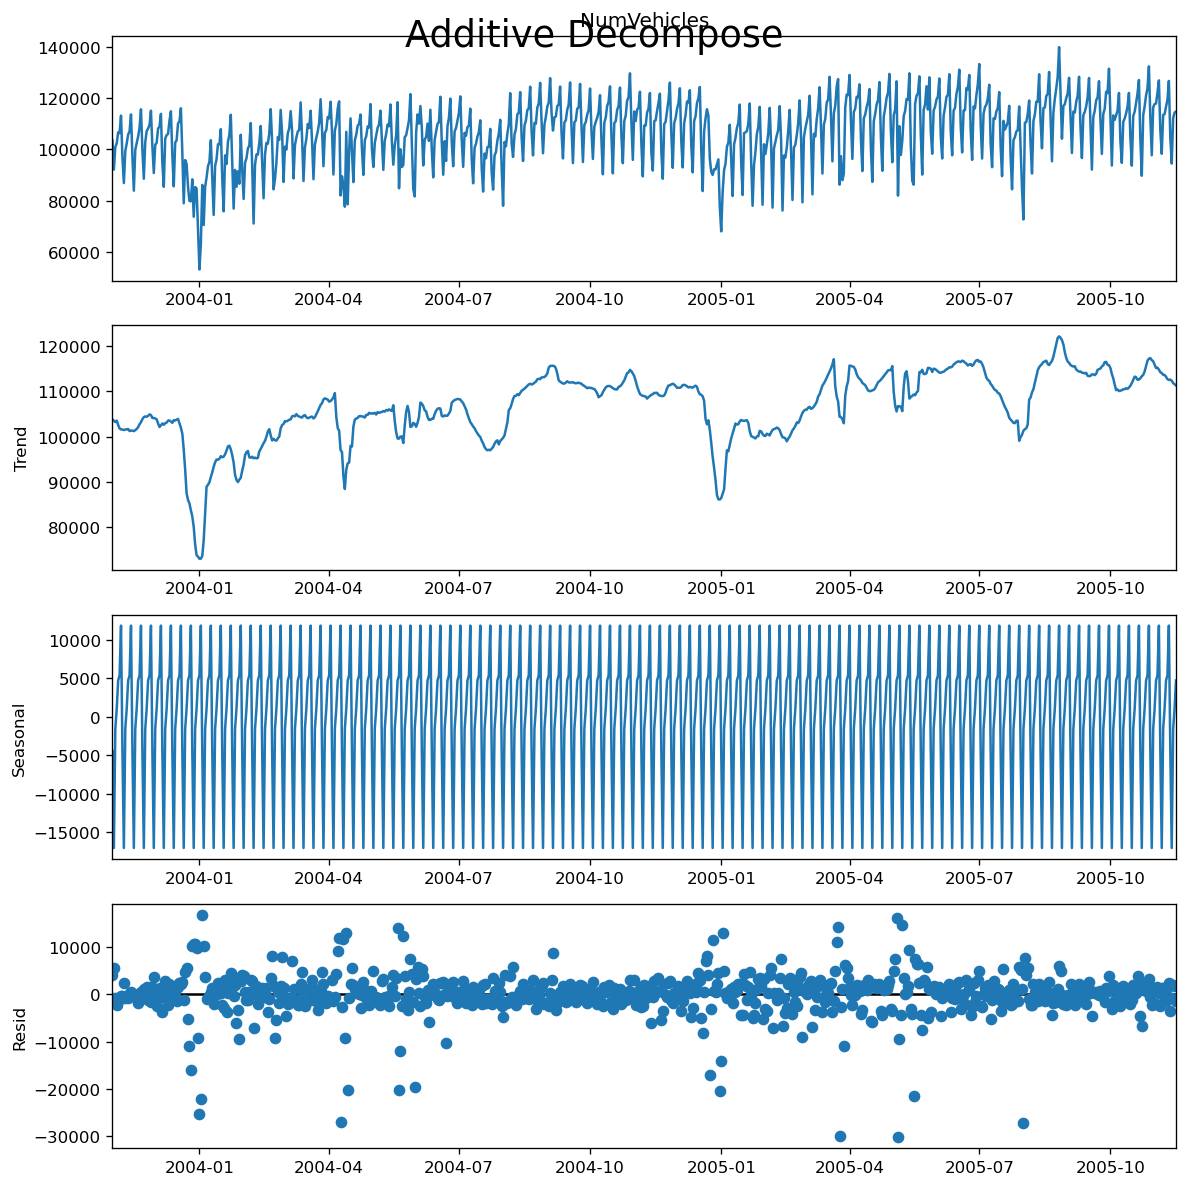

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['NumVehicles'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['NumVehicles'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


In [32]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2003-11-01,0.959682,103809.928571,1.039262,103536.0
2003-11-02,0.840922,103510.341837,1.057521,92051.0
2003-11-03,0.985553,103210.755102,0.990909,100795.0
2003-11-04,1.010688,103528.285714,0.978183,102352.0
2003-11-05,1.043982,102566.857143,0.995247,106569.0


In [68]:
df=df.dropna()
df.head(10)

,NumVehicles,Time,year,month,day,week,dayofweek,NumVehicles_deseason
Date,,,,,,,,
2003-11-22,99758,21,2003,Nov,22,47,Saturday,2692.0
2003-11-23,88487,22,2003,Nov,23,47,Sunday,4639.0
2003-11-24,102773,23,2003,Nov,24,48,Monday,3003.0
2003-11-25,107040,24,2003,Nov,25,48,Tuesday,4759.0
2003-11-26,108092,25,2003,Nov,26,48,Wednesday,3141.0
2003-11-27,109490,26,2003,Nov,27,48,Thursday,1093.0
2003-11-28,115048,27,2003,Nov,28,48,Friday,-519.0
2003-11-29,101161,28,2003,Nov,29,48,Saturday,1403.0
2003-11-30,90733,29,2003,Nov,30,48,Sunday,2246.0
